<a href="https://colab.research.google.com/github/Aliht72/Big-Data/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless

In [16]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz


--2022-05-09 16:27:48--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  30.9MB/s    in 11s     

2022-05-09 16:27:59 (23.8 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



In [17]:
!tar xf spark-3.2.1-bin-hadoop2.7.tgz


In [18]:
!pip install -q findspark


In [19]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [20]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

In [21]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("DataCleaningApp")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [22]:
spark

In [23]:
df = spark.read.csv("combined-data.csv", header=True, inferSchema=True)

In [24]:
removeAllNA = df.na.drop()

In [25]:
removeAllNA.count()

1411

In [26]:
df.count()

4619

In [27]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

--2022-05-09 16:28:41--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 52.202.168.65, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  46.8MB/s    in 0.3s    

2022-05-09 16:28:41 (46.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
{"tunnels":[],"uri":"/api/tunnels"}


In [28]:
from itertools import cycle, islice
from math import sqrt
from numpy import array
from pandas.plotting import parallel_coordinates
from pyspark.ml.clustering import KMeans as KM
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection   = featuresAndPrediction.rdd.map(array)

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)


def elbow(elbowset, clusters):
	wsseList = []	
	for k in clusters:
		print("Training for cluster size {} ".format(k))
		kmeans = KM(k = k, seed = 1)
		model = kmeans.fit(elbowset)
		transformed = model.transform(elbowset)
		featuresAndPrediction = transformed.select("features", "prediction")

		W = computeCost(featuresAndPrediction, model)
		print("......................WSSE = {} ".format(W))

		wsseList.append(W)
	return wsseList

def elbow_plot(wsseList, clusters):
	wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
	wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

def parallel_plot(data, P):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(P)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [29]:
removeAllNA.describe().toPandas().transpose()


,0,1,2,3,4
summary,count,mean,stddev,min,max
userId,1411,1201.0751240255138,691.9957569853385,1,2387
userSessionId,1411,19166.43869596031,7451.158753782938,5652,38321
teamLevel,1411,4.834160170092133,1.7914678556629045,1,7
platformType,1411,None,None,android,windows
count_gameclicks,1411,145.23458540042523,119.76291399660911,6,982
count_hits,1411,16.758327427356484,13.565930146754264,0,100
count_buyId,1411,1.6832034018426647,0.9005088871085436,1,6
avg_price,1411,7.214323175053155,6.536501375588665,1.0,20.0


In [30]:
workingDF = removeAllNA.drop('userId').drop('userSessionId')


In [31]:
from pyspark.sql import functions as F
categories = workingDF.select("platformType").distinct().rdd.flatMap(lambda x: x).collect()

exprs = [F.when(F.col("platformType") == category, 1).otherwise(0).alias(category)
         for category in categories]

AfterDummy = removeAllNA.select("count_buyId", "avg_price" , "count_hits" , "count_gameclicks" , "teamLevel" ,  *exprs)


In [32]:
from pyspark.sql.functions import monotonically_increasing_id 

AfterDummy= AfterDummy.select("*").withColumn("rowID", monotonically_increasing_id())


In [33]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
featuresUsed = ['teamLevel',  'count_gameclicks', 'count_hits', 'count_buyId', 
        'avg_price' , "iphone" , "android"  , "linux" , "mac" , "windows" ]
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(AfterDummy)

In [34]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [35]:
scaledData = scaledData.select("features", "rowID")
elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

In [36]:
clusters = range(2,31)

wsseList = elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 1330.6003176208835 
Training for cluster size 3 
......................WSSE = 1120.3882749469185 
Training for cluster size 4 
......................WSSE = 1039.0133577573733 
Training for cluster size 5 
......................WSSE = 952.2888884811715 
Training for cluster size 6 
......................WSSE = 826.8580988927658 
Training for cluster size 7 
......................WSSE = 787.2107467784595 
Training for cluster size 8 
......................WSSE = 771.5035449895054 
Training for cluster size 9 
......................WSSE = 754.132251085829 
Training for cluster size 10 
......................WSSE = 730.7854760901855 
Training for cluster size 11 
......................WSSE = 704.5661383753041 
Training for cluster size 12 
......................WSSE = 664.5380693320985 
Training for cluster size 13 
......................WSSE = 657.4494246782355 
Training for cluster size 14 
......................WSSE = 630.6613126

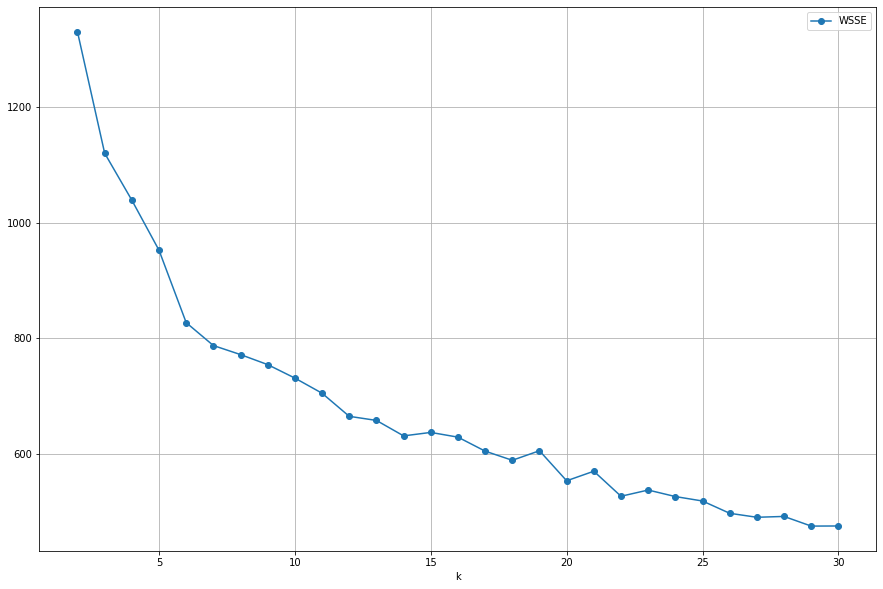

In [37]:
elbow_plot(wsseList, clusters)


In [38]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

In [39]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [40]:
centers = model.clusterCenters()
centers

[array([-1.16013592, -0.35818581, -0.34989857, -0.33257026,  1.76333255,
         1.2414706 , -0.75555583, -0.2700964 , -0.17934453, -0.40978929]),
 array([ 0.79032388, -0.23217053, -0.25093456,  0.42582952, -0.46027271,
        -0.80492545,  1.32259092, -0.2700964 , -0.17934453, -0.40978929]),
 array([ 0.17046062,  0.0539657 ,  0.04010032, -0.06140575, -0.32079567,
        -0.80492545, -0.75555583, -0.2700964 ,  5.5719084 , -0.40978929]),
 array([ 0.12997729, -0.15216961, -0.20294759,  0.08848685, -0.75513196,
        -0.80492545, -0.75555583, -0.2700964 , -0.17934453,  2.43854906]),
 array([-0.97190519, -0.48333617, -0.51018382, -0.39713323,  0.08817783,
         1.2414706 , -0.75555583, -0.2700964 , -0.17934453, -0.40978929]),
 array([-0.20513542, -0.1272062 , -0.17220384,  0.00631364, -0.90297895,
        -0.80492545, -0.75555583,  3.69975793, -0.17934453, -0.40978929]),
 array([ 0.67845293, -0.07876339,  0.03487247, -0.37322892,  1.81696373,
         1.2414706 , -0.75555583, -0.27

In [41]:
centers = model.clusterCenters()
centers

[array([-1.16013592, -0.35818581, -0.34989857, -0.33257026,  1.76333255,
         1.2414706 , -0.75555583, -0.2700964 , -0.17934453, -0.40978929]),
 array([ 0.79032388, -0.23217053, -0.25093456,  0.42582952, -0.46027271,
        -0.80492545,  1.32259092, -0.2700964 , -0.17934453, -0.40978929]),
 array([ 0.17046062,  0.0539657 ,  0.04010032, -0.06140575, -0.32079567,
        -0.80492545, -0.75555583, -0.2700964 ,  5.5719084 , -0.40978929]),
 array([ 0.12997729, -0.15216961, -0.20294759,  0.08848685, -0.75513196,
        -0.80492545, -0.75555583, -0.2700964 , -0.17934453,  2.43854906]),
 array([-0.97190519, -0.48333617, -0.51018382, -0.39713323,  0.08817783,
         1.2414706 , -0.75555583, -0.2700964 , -0.17934453, -0.40978929]),
 array([-0.20513542, -0.1272062 , -0.17220384,  0.00631364, -0.90297895,
        -0.80492545, -0.75555583,  3.69975793, -0.17934453, -0.40978929]),
 array([ 0.67845293, -0.07876339,  0.03487247, -0.37322892,  1.81696373,
         1.2414706 , -0.75555583, -0.27

In [51]:
P = pd_centers(featuresUsed, centers)


No handles with labels found to put in legend.


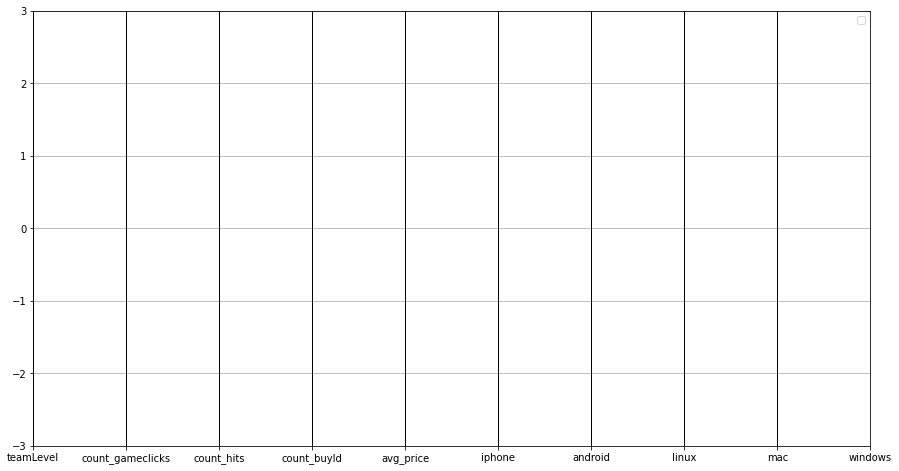

In [53]:
parallel_plot(P[P['avg_price'] > 5], P)


#Clustering
